In [7]:
print(np.arange(1e-5, 1+1e-5, 1e-5))

[1.0000e-05 2.0000e-05 3.0000e-05 ... 9.9998e-01 9.9999e-01 1.0000e+00]


In [8]:
import sys
import os
import math
from math import pi
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.fftpack import fft, ifft
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import firwin2,welch

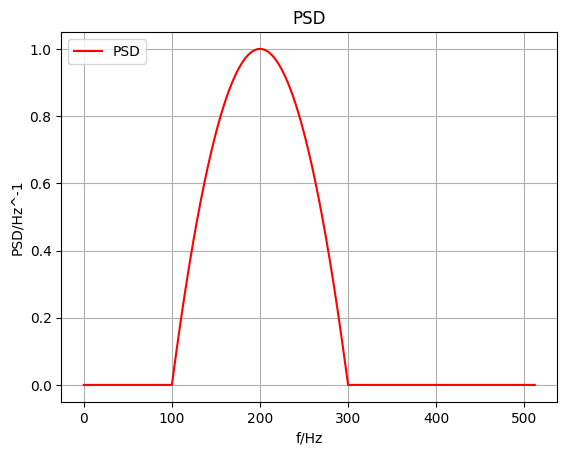

In [9]:
samp_freq=2
n_samp=16384
time_vec=1/samp_freq*np.arange(0,n_samp,1)
def targetPSD(f):
    out=np.zeros(len(f))
    for i in range(0,len(f)):
        if (100 <= f[i]) and (f[i]<= 300):
            out[i]=(f[i] - 100) * (300 - f[i]) / 10000
        else:
            out[i]=0
    return out
freq=np.arange(0,512.1,0.1)
PSD=targetPSD(freq)
plt.plot(freq,PSD,'r',label="PSD")
plt.grid(True)
plt.xlabel("f/Hz")
plt.ylabel("PSD/Hz^-1")
plt.legend(loc='upper left')
plt.title("PSD")
plt.show()


In [10]:
import numpy as np

def fftfilt(b, x):
    """Use FFT to apply FIR filter defined by b to signal x."""
    # 获取输入信号和滤波器的长度
    N_x = len(x)
    N_b = len(b)
    
    # 计算 FFT 的大小
    N = N_x + N_b - 1
    
    # 计算滤波器和输入信号的 FFT
    X = np.fft.fft(x, N)
    B = np.fft.fft(b, N)
    
    # 乘以滤波器的频率响应
    Y = X * B
    
    # 计算逆 FFT 以获得滤波后的信号
    y = np.fft.ifft(Y)
    
    # 取出中间的部分，与输入信号长度相同
    start = (N_b - 1) // 2
    y = y[start:start + N_x]
    
    # 只取实部（虚部应该非常接近零）
    return np.real(y)

# 示例
b = np.random.randn(500)
x = np.random.randn(16384)
y = fftfilt(b, x)

print(len(y))  # 输出应为 16384


16384


In [11]:
def stat_gauss_noise(n_samp,freq,PSD,flt_ord,samp_freq):
    sqrt_PSD=np.sqrt(PSD)
    sqrt_PSD[-1]=0
    #b=firwin2(flt_ord,freq/(samp_freq/2),sqrt_PSD)
    b=firwin2(flt_ord,freq/(samp_freq/2),sqrt_PSD)
    in_noise=np.random.randn(1,n_samp)
    # print(in_noise.shape,b.shape)
    # print(fftfilt(b,in_noise[0]).shape)
    return np.sqrt(samp_freq)*fftfilt(b,in_noise[0])


In [12]:
flt_ord=500
out_noise=stat_gauss_noise(n_samp,freq,PSD,flt_ord,samp_freq)
f,Px=welch(out_noise,samp_freq,'hann',256)
f=f.reshape(1,-1)
#print(f.shape,Px.shape)

plt.plot(f[0],Px,'r',label="PSD")
plt.grid(True)
plt.xlabel("f/Hz")
plt.ylabel("PSD/Hz^-1")
plt.legend(loc='upper left')
plt.title("PSD")
plt.show()

#print(out_noise.shape)
plt.plot(time_vec,out_noise,'r',label="stat_gauss_noise")
plt.grid(True)
plt.xlabel("t/s")
plt.ylabel("noise")
plt.legend(loc='upper left')
plt.title("stat_gauss_noise")
plt.show()

ValueError: freq must start with 0 and end with fs/2.

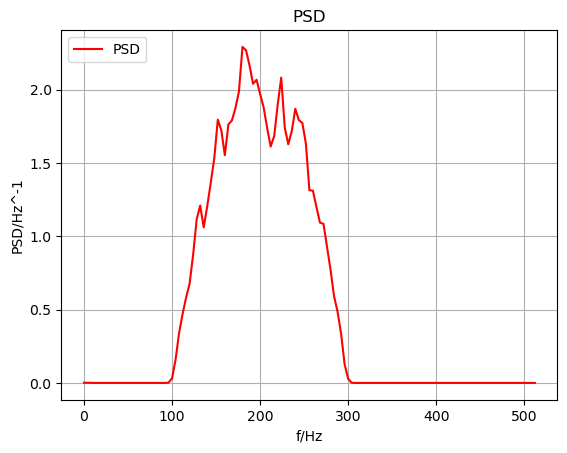

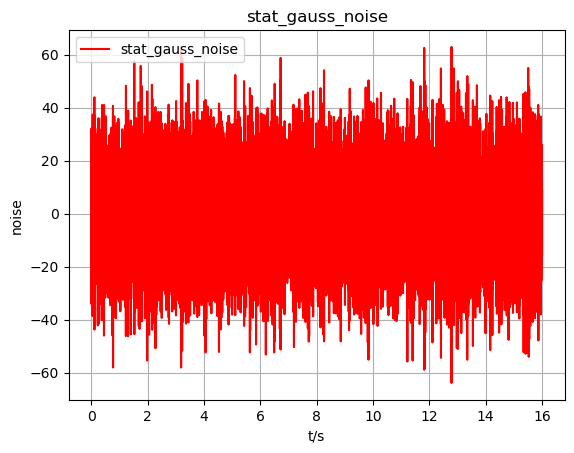

In [6]:
flt_ord=500
out_noise=stat_gauss_noise(n_samp,freq,PSD,flt_ord,samp_freq)
f,Px=welch(out_noise,samp_freq,'hann',256)
f=f.reshape(1,-1)
#print(f.shape,Px.shape)

plt.plot(f[0],Px,'r',label="PSD")
plt.grid(True)
plt.xlabel("f/Hz")
plt.ylabel("PSD/Hz^-1")
plt.legend(loc='upper left')
plt.title("PSD")
plt.show()

#print(out_noise.shape)
plt.plot(time_vec,out_noise,'r',label="stat_gauss_noise")
plt.grid(True)
plt.xlabel("t/s")
plt.ylabel("noise")
plt.legend(loc='upper left')
plt.title("stat_gauss_noise")
plt.show()

In [13]:
import numpy as np 
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries

def generate_noise_from_psd(N, freqVec,psd, num_noises=1,freq_range=[-1,999], sample_rate = 4096, duration = None):
    #freqVec = np.linspace(0, sample_rate/2, len(psd))
    noises = np.zeros((num_noises, N))
    interpolated_asds = []
    for i in range(num_noises):
        WGN = np.random.randn(N)
        X = np.fft.rfft(WGN) / np.sqrt(N)
        asd = np.sqrt(psd)
        uneven = N % 2
        # Simulate the white noise of rFFT
        # X = (np.random.randn(N // 2 + 1 + uneven) + 1j * np.random.randn(N // 2 + 1 + uneven))
        
        selected_indices = np.where((freqVec >= freq_range[0]) & (freqVec <= freq_range[1]))[0]
        #print(selected_indices)
        # Interpolate selected ASD values to match the length of X
        interp_asd = interp1d(freqVec[selected_indices],asd[selected_indices], kind='linear', bounds_error=False, fill_value="extrapolate")
        newFreqVec = np.fft.rfftfreq(N+uneven, d=1.0/sample_rate)
        #print(newFreqVec)
        interpolated_asd = interp_asd(newFreqVec)
        nonSelected_indices = np.where(~ ((newFreqVec> freq_range[0]) & (newFreqVec < freq_range[1])))[0]
        interpolated_asd[nonSelected_indices] = 1e-30
        # interpolated_asd[interpolated_asd<1e-30] = 1e-30

        # Apply the random ASD to create colored noise
        # In order to keep the nSample equal to before
        Y_colored = X * interpolated_asd
        y_colored = np.fft.irfft(Y_colored).real * np.sqrt(N*sample_rate)
        if uneven:
            y_colored = y_colored[:-1]
        
        noises[i, :] = y_colored 
        interpolated_asds.append(interpolated_asd)
        #print(noises)
        
    return noises, interpolated_asds


In [14]:
import numpy as np
from math import pi 
c =2.9979246*1e8
def PSD_Lisa_no_Response(f):
    
    """
    From https://arxiv.org/pdf/1803.01944.pdf. 
    """

    L = 2.5*10**9   # Length of LISA arm
    f0 = c/(2*pi*L)   
    
    Poms = ((1.5*10**-11)**2)*(1 + ((2*10**-3)/f)**4)  # Optical Metrology Sensor
    Pacc = (3*10**-15)**2*(1 + (4*10**-3/(10*f))**2)*(1 + (f/(8*10**-3))**4)  # Acceleration Noise
    Sc = 9*10**(-45)*f**(-7/3)*np.exp(-f**0.171 + 292*f*np.sin(1020*f)) * (1 \
                                            + np.tanh(1680*(0.00215 - f)))   # Confusion noise
    alpha = 0.171
    beta = 292
    k =1020
    gamma = 1680
    f_k = 0.00215 
    PSD = ((1/(L*L))*(Poms + (4*Pacc)/(np.power(2*pi*f,4))) + Sc) # PSD
        
    # Handling the zeroth frequency bin
    
    where_are_NaNs = np.isnan(PSD) 
    PSD[where_are_NaNs] = 1e100    # at f = 0, PSD is infinite. Approximate infinity and burn my 
                                   # mathematics degree to the ground. 
    
    return PSD

200000
[[-5.22014577e-17 -5.22018759e-17 -5.21967984e-17 ...
  -5.22035529e-17 -5.22125396e-17 -5.21991243e-17]]


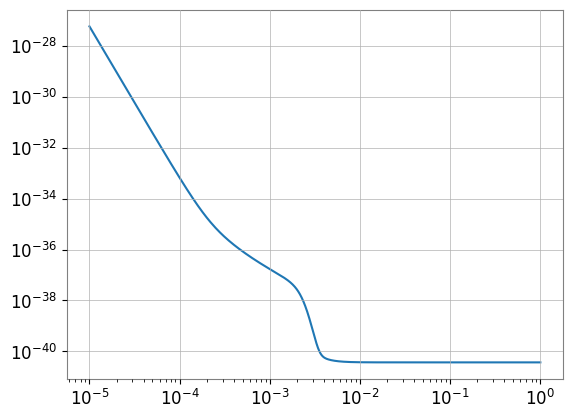

In [15]:
freq=np.arange(1e-5,1+1e-5,1e-5)
N=round(2/1e-5)
print(N)
noise,_=generate_noise_from_psd(N,freq,PSD_Lisa_no_Response(freq)/2,sample_rate=2)
time=1/2*np.arange(0,N)
print(noise)
plt.loglog(freq,PSD_Lisa_no_Response(freq))

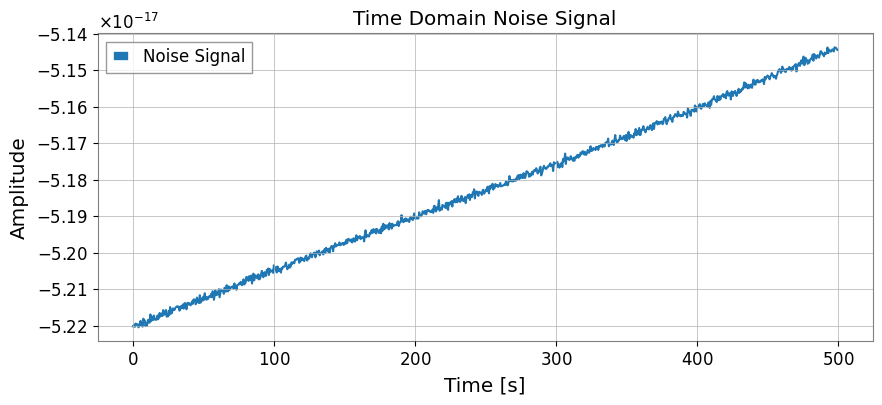

In [16]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 4))

plt.plot(time[:1000], noise[0][:1000], label='Noise Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Time Domain Noise Signal')
plt.legend()
plt.grid(True)
plt.show()

[0.0078125 0.015625  0.0234375 0.03125   0.0390625 0.046875
 0.0546875 0.0625    0.0703125 0.078125  0.0859375 0.09375
 0.1015625 0.109375  0.1171875 0.125     0.1328125 0.140625
 0.1484375 0.15625   0.1640625 0.171875  0.1796875 0.1875
 0.1953125 0.203125  0.2109375 0.21875   0.2265625 0.234375
 0.2421875 0.25      0.2578125 0.265625  0.2734375 0.28125
 0.2890625 0.296875  0.3046875 0.3125    0.3203125 0.328125
 0.3359375 0.34375   0.3515625 0.359375  0.3671875 0.375
 0.3828125 0.390625  0.3984375 0.40625   0.4140625 0.421875
 0.4296875 0.4375    0.4453125 0.453125  0.4609375 0.46875
 0.4765625 0.484375  0.4921875 0.5       0.5078125 0.515625
 0.5234375 0.53125   0.5390625 0.546875  0.5546875 0.5625
 0.5703125 0.578125  0.5859375 0.59375   0.6015625 0.609375
 0.6171875 0.625     0.6328125 0.640625  0.6484375 0.65625
 0.6640625 0.671875  0.6796875 0.6875    0.6953125 0.703125
 0.7109375 0.71875   0.7265625 0.734375  0.7421875 0.75
 0.7578125 0.765625  0.7734375 0.78125   0.7890625 0.79

/tmp/ipykernel_15055/3584627658.py:24: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-39)


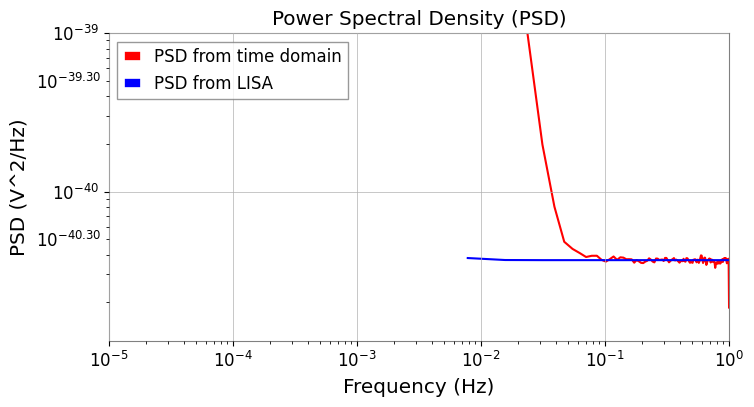

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# 示例序列（可以替换成你自己的序列）
signal = np.random.randn(1024)  # 生成一个随机信号作为示例

# 定义采样率
fs = 1000  # 示例采样率为 1000 Hz

# 使用 Welch 方法计算 PSD
frequencies, psd = welch(noise[0], 2, nperseg=256)

# 打印频率和 PSD 值
print(frequencies[1:])
print(psd[1:])
print(PSD_Lisa_no_Response(frequencies[1:]))
# 可视化 PSD
plt.figure(figsize=(8, 4))
plt.loglog(frequencies[1:],psd[1:],'-r',label='PSD from time domain')

plt.loglog(frequencies[1:],PSD_Lisa_no_Response(frequencies[1:]),'-b',label='PSD from LISA')
plt.xlim(1e-5,1)
plt.ylim(0,1e-39)
plt.legend()
plt.title('Power Spectral Density (PSD)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.grid(True)
plt.show()


In [18]:
import numpy as np
from scipy.signal import butter, filtfilt, get_window
from scipy.fft import rfft, irfft
from scipy.interpolate import interp1d

def whiten(data, sample_rate, fftlength=2, overlap=0, method='median', 
                window='hann', detrend='constant', psd=None, 
                fduration=2, highpass=None):
    """
    完整复现 TimeSeries 白化功能的函数

    参数:
    ----------
    data : `numpy.ndarray`
        输入的时间序列数据
    sample_rate : `float`
        采样率
    fftlength : `float`
        FFT 积分时长（以秒为单位）
    overlap : `float`
        FFT 窗口重叠部分的时长（以秒为单位）
    method : `str`
        ASD 估计方法 ('median', 'bartlett', 'welch')
    window : `str`
        窗口类型，默认为 'hann'，可以是 `scipy.signal.get_window` 支持的任何窗口
    detrend : `str`
        去趋势方法 ('constant', 'linear')
    asd : `numpy.ndarray`, optional
        ASD ：如果已经有 ASD ，可以直接传入不再计算
    fduration : `float`
        FIR 滤波器的时长（以秒为单位）
    highpass : `float`, optional
        高通滤波器的截止频率，默认为 None

    返回:
    ----------
    whitened_data : `numpy.ndarray`
        白化后的数据
    """
    
    # Step 1: 计算 ASD（使用 FFT）
    N = len(data)
    freqs = np.fft.rfftfreq(N, d=1.0/sample_rate)
    
    if psd is None:
        # 没有给定 ASD，则通过 FFT 计算
        psd = np.abs(np.fft.rfft(data))**2 / N
        asd = np.sqrt(psd)  # ASD 是 PSD 的平方根
        
        # 确保 freqs 和 asd 的长度一致
        if len(freqs) != len(asd):
            min_len = min(len(freqs), len(asd))
            freqs = freqs[:min_len]
            asd = asd[:min_len]

        # 插值 ASD
        interp_asd = interp1d(freqs, asd, kind='linear', fill_value="extrapolate")
        ASD = interp_asd(freqs)
    else:
        PSD=psd(freqs)
        ASD=np.sqrt(PSD)
    # Step 2: 设计 FIR 滤波器（基于 ASD）
    ntaps = int(fduration * sample_rate)
    
    # Step 3: 高通滤波器（可选）
    if highpass:
        nyquist = 0.5 * sample_rate
        norm_highpass = highpass / nyquist
        b_high, a_high = butter(4, norm_highpass, btype='high')
        data = filtfilt(b_high, a_high, data)
    
    # Step 4: 白化滤波器设计（逆 ASD 作为滤波器）
    whiten_filter = 1.0 / ASD
    whiten_filter[:len(whiten_filter)//2] = np.maximum(whiten_filter[:len(whiten_filter)//2], 1e-10)  # 避免除零

    # 生成窗口
    window_vals = get_window(window, N, fftbins=False)
    
    # Step 5: 应用白化滤波器
    # 进行 FFT，将数据转换到频域
    fft_data = rfft(data * window_vals)
    whitened_freq = fft_data * whiten_filter
    whitened_time = irfft(whitened_freq)
    
    # Step 6: 去趋势，恢复时间域信号
    if detrend == 'constant':
        whitened_time -= np.mean(whitened_time)
    elif detrend == 'linear':
        whitened_time -= np.polyval(np.polyfit(np.arange(N), whitened_time, 1), np.arange(N))

    return whitened_time,freqs,ASD


/tmp/ipykernel_15055/2174002029.py:13: RuntimeWarning: divide by zero encountered in divide
  Poms = ((1.5*10**-11)**2)*(1 + ((2*10**-3)/f)**4)  # Optical Metrology Sensor
/tmp/ipykernel_15055/2174002029.py:14: RuntimeWarning: divide by zero encountered in divide
  Pacc = (3*10**-15)**2*(1 + (4*10**-3/(10*f))**2)*(1 + (f/(8*10**-3))**4)  # Acceleration Noise
/tmp/ipykernel_15055/2174002029.py:15: RuntimeWarning: divide by zero encountered in power
  Sc = 9*10**(-45)*f**(-7/3)*np.exp(-f**0.171 + 292*f*np.sin(1020*f)) * (1 \


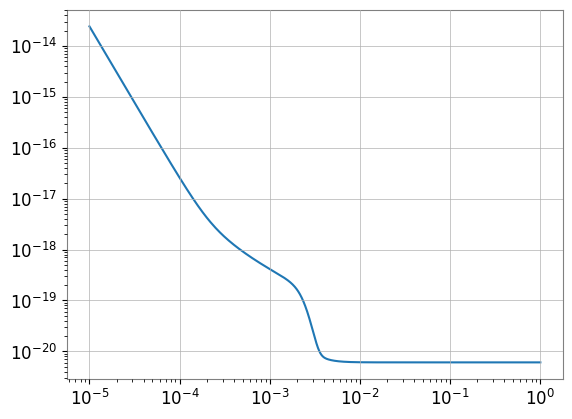

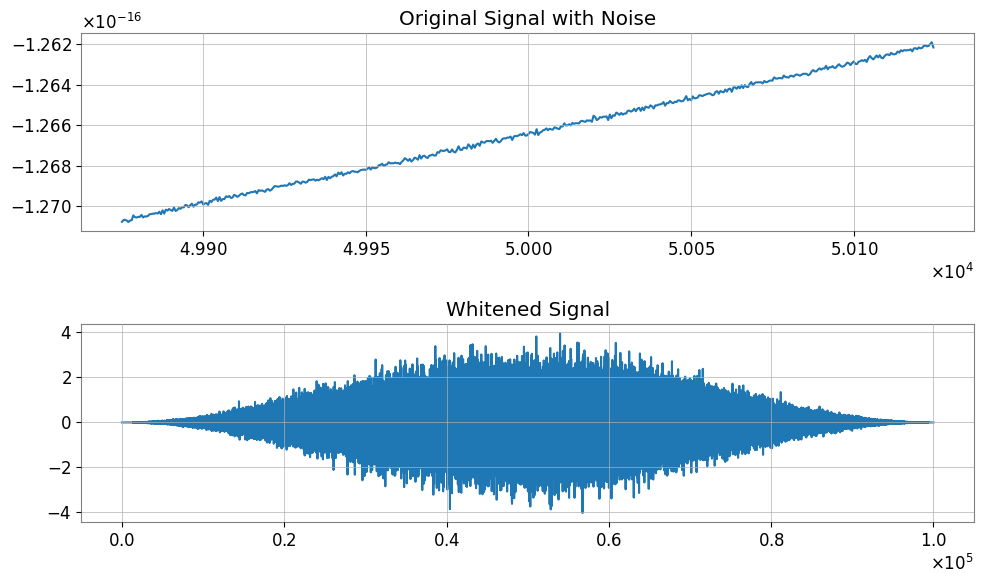

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# 生成示例数据（带噪声的正弦波）
length=500
start=int(1/2*(len(time)-length))
# 白化处理
whitened_signal,freqs,asd = whiten(noise[0], sample_rate=2,psd=PSD_Lisa_no_Response,highpass=2e-3)
plt.loglog(freqs,asd)
#plt.loglog(freqs,np.sqrt(PSD_Lisa_no_Response(freqs)))
# 可视化原始和白化后的信号
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(time[start:start+length], noise[0][start:start+length])
plt.title('Original Signal with Noise')
plt.subplot(2, 1, 2)
plt.plot(time, whitened_signal)
plt.title('Whitened Signal')
plt.tight_layout()
plt.show()


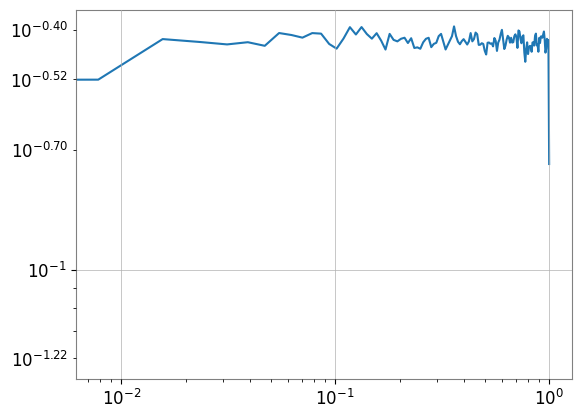

In [20]:
frequencies, psd = welch(whitened_signal, 2, nperseg=256)
plt.loglog(frequencies,psd)